In [1]:
using DrWatson
using GenerativeMIL
using Flux
using Flux3D: chamfer_distance
using MLDataPattern
using ProgressMeter: Progress, next!
using PaddedViews
using PyPlot
using Distances

┌ Info: Precompiling GenerativeMIL [4ec10b0d-33ec-5e6b-88b9-838b82d80493]
└ @ Base loading.jl:1423
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **



In [2]:
function unmask(x, mask, output_dim=3)
    x = reshape(x, (output_dim,:))
    mask = reshape(mask, (1,:))
    x_masked = ones(size(x)...) .* mask
    x = reshape(x[x_masked .== 1], (output_dim,:))
    return x
end

function masked_chamfer_distance(x, y, x_mask, y_mask)
    return Flux.mean([
            chamfer_distance(
                unmask(x[:,:,i:i],x_mask[:,:,i:i]), 
                unmask(y[:,:,i:i],y_mask[:,:,i:i])
            ) for i=1:size(x,1)])
end

masked_chamfer_distance (generic function with 1 method)

In [3]:
function loss_f(m::GenerativeMIL.Models.SetVAE, x::AbstractArray{<:Real}, x_mask::AbstractArray{Bool}, β::Float32=0.01f0)
    #encoder
    x1 = m.encoder.expansion(x) .* x_mask
    x1, h_enc1 = m.encoder.layers[1](x1, x_mask)
    x1, h_enc2 = m.encoder.layers[2](x1, x_mask)
    x1, h_enc3 = m.encoder.layers[3](x1, x_mask)
    x1, h_enc4 = m.encoder.layers[4](x1, x_mask)
    
    #println("encoder", x1)
    _, sample_size, bs = size(x_mask)
    z = m.prior(sample_size, bs)
    #println("sampling", z)
    #decoder
    klds = 0
    x1 = m.decoder.expansion(z) .* x_mask
    x1, kld, _,_ = m.decoder.layers[1](x1, h_enc4, x_mask)
    klds += kld
    x1, kld, _,_ = m.decoder.layers[2](x1, h_enc3, x_mask)
    klds += kld
    x1, kld, _,_ = m.decoder.layers[3](x1, h_enc2, x_mask)
    klds += kld
    x1, kld, _,_ = m.decoder.layers[4](x1, h_enc1, x_mask)
    klds += kld
    x1 = m.decoder.reduction(x1) .* x_mask
    #println("decoder", x1)
    loss = masked_chamfer_distance(x, x1, x_mask, x_mask) + β * klds
    #loss = Flux.mse(x,x1) + β * klds
    #loss = chamfer_distance(x, x1) + β * klds
    return loss, klds, Flux.var(x1)
end

loss_f (generic function with 2 methods)

In [3]:
function transform_batch1(x, max=false)
    a_mask = [ones(size(a)) for a in x];
    if max
        max_set = maximum(size.(x))[end];
    else
        max_set = minimum(size.(x))[end]; #minimum
    end
    b = map(a->Array{Float32}(PaddedView(0, a, (3, max_set))), x);
    b_mask = map(a->Array(PaddedView(0, a, (3, max_set))), a_mask);
    c = cat(b..., dims=3);
    c_mask = cat(b_mask..., dims=3) .> 0; # mask as BitArray
    c_mask = Array(c_mask[1:1,:,:]);
    return c, c_mask
end

transform_batch1 (generic function with 2 methods)

In [4]:
train, test = GenerativeMIL.Models.load_and_standardize_mnist();

┌ Info: train standardized μ = [14.010735081757533; 13.027597697882937; 174.257433938215;;], σ = [4.270086778902686; 5.572331140597686; 87.89041202121322;;]
└ @ GenerativeMIL.Models F:\AI Center\GenerativeMIL\src\models\utils\dataset.jl:137


In [5]:
dataloader = RandomBatches(train[1], size=32)

RandomBatches(::Vector{Any}, 32, ObsDim.Last())
 Iterator providing Inf batches of size 32

In [9]:
#loss, back = Flux.pullback(ps) do 
#    loss_f(sv, x, x_mask, 0f0) 
#end;

In [10]:
#grad = back(1f0);
#Flux.Optimise.update!(opt, ps, grad);

In [43]:
sv = GenerativeMIL.Models.SetVAE(3,32,4,[16,8,4,2], [2,4,8,16], 3, 5, Flux.relu);
sv_tmp = deepcopy(sv);
ps = Flux.params(sv);
opt = ADAM(lt=1e-3)
losses = []
iters = 1000
sizes = []
progress = Progress(iters)
beta = 0.01f0
for (i, batch) in enumerate(dataloader)
    x, x_mask = transform_batch1(batch,true)#GenerativeMIL.Models.transform_batch(batch)
    #x = Flux.sigmoid.(x)
    push!(sizes, size(x,2))
    #println(x|>size, x_mask|>size)
    loss, back = Flux.pullback(ps) do 
        loss_f(sv, x, x_mask, beta) 
    end;
    grad = back((1f0,0f0,0f0));
    Flux.Optimise.update!(opt, ps, grad);
    #@info "loss = $(loss)"
    push!(losses, loss)
    next!(progress; showvalues=[(:iters, "$(i)/$(iters)"),(:loss, loss[1]),(:klds, loss[2])])
    if i == 10000
        beta = 0.01f0
    elseif i ==iters
        break
    end
end

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter C:\Users\ghost_000\.julia\packages\ProgressMeter\sN2xr\src\ProgressMeter.jl:618
Progress: 100%|█████████████████████████████████████████| Time: 0:05:40
  iters:  1000/1000
  loss:   3.303705098576656
  klds:   2.400839615613222


In [44]:
print(Flux.mean(Flux.params(sv_tmp.encoder).==Flux.params(sv.encoder)), "|")
print(Flux.mean(Flux.params(sv_tmp.decoder).==Flux.params(sv.decoder)), "|")
print(Flux.mean(Flux.params(sv_tmp.prior).==Flux.params(sv.prior)))

0.0|0.0|0.0

In [45]:
print(Flux.sum(Flux.params(sv_tmp.encoder).==Flux.params(sv.encoder)), "|")
print(Flux.sum(Flux.params(sv_tmp.decoder).==Flux.params(sv.decoder)), "|")
print(Flux.sum(Flux.params(sv_tmp.prior).==Flux.params(sv.prior)))

0|0|0

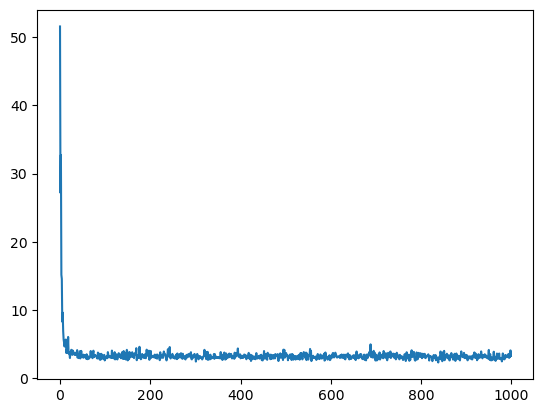

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000002450B20>

In [46]:
plot(map(x->x[1], losses))#plot(losses)

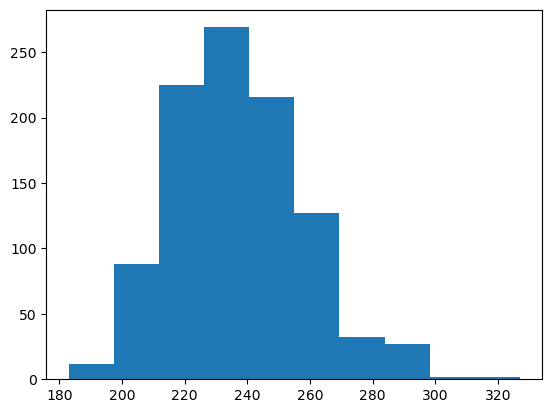

In [47]:
hist(sizes);

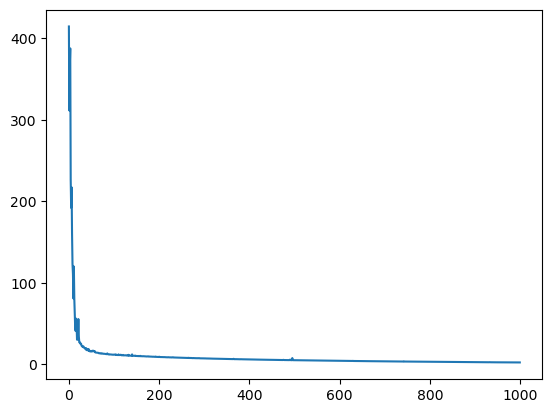

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000002667970>

In [48]:
plot(map(x->x[2], losses))

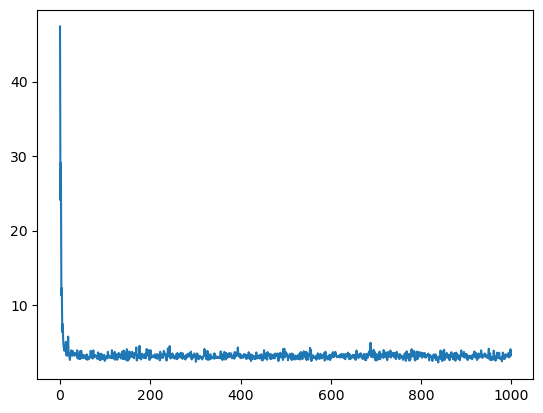

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000B735ABE0>

In [56]:
plot(map(x->x[1] - beta * x[2], losses))

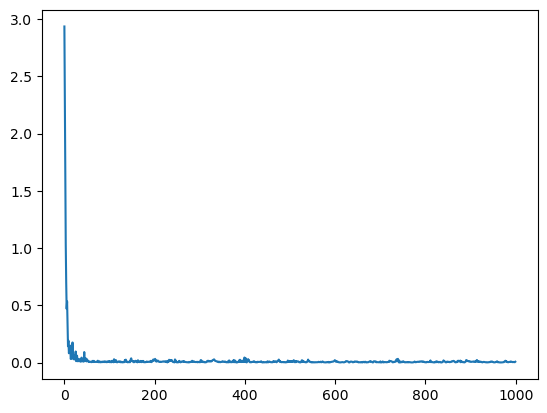

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000B73BBA00>

In [57]:
plot(map(x->x[3], losses))#plot(losses)

In [14]:
dafasfasfasf

LoadError: UndefVarError: dafasfasfasf not defined

In [6]:
xx = 0
xx_mask = 0
for test in dataloader
    
    #println(typeof.(transform_batch1(test, true)))
    xx, xx_mask = transform_batch1(test, true)
    #xx = Flux.sigmoid.(xx
    break
end

In [99]:
function forw(m::GenerativeMIL.Models.SetVAE, x::AbstractArray{<:Real}, x_mask::AbstractArray{Bool}, β::Float32=0.01f0)
    #encoder
    x1 = m.encoder.expansion(x) .* x_mask
    x1, h_enc1 = m.encoder.layers[1](x1, x_mask)
    x1, h_enc2 = m.encoder.layers[2](x1, x_mask)
    x1, h_enc3 = m.encoder.layers[3](x1, x_mask)
    x1, h_enc4 = m.encoder.layers[4](x1, x_mask)
    
    _, sample_size, bs = size(x_mask)
    z = m.prior(sample_size, bs)
    #z = randn(Float32, 3,sample_size, bs)
    #decoder
    klds = 0
    x1 = m.decoder.expansion(z) .* x_mask
    x1, kld, _,_ = m.decoder.layers[1](x1, h_enc4, x_mask)
    klds += kld
    x1, kld, _,_ = m.decoder.layers[2](x1, h_enc3, x_mask)
    klds += kld
    x1, kld, _,_ = m.decoder.layers[3](x1, h_enc2, x_mask)
    klds += kld
    x1, kld, _,_ = m.decoder.layers[4](x1, h_enc1, x_mask)
    klds += kld
    x1 = m.decoder.reduction(x1) .* x_mask
    return x1, z
end

forw (generic function with 2 methods)

In [100]:
sv = GenerativeMIL.Models.SetVAE(3,64,4,[16,8,4,1], [2,4,8,16], 5, 32, Flux.swish);

In [101]:
sv.decoder;

In [102]:
sv.decoder.expansion.W |> GenerativeMIL.Models.check

size -> (64, 3) | type -> Matrix{Float32} | mean -> -0.011077459 | var -> 0.034415096 | sum -> -2.126872 | not zero elements -> 192) 


In [103]:
y,_ = forw(sv, xx, xx_mask);

local function


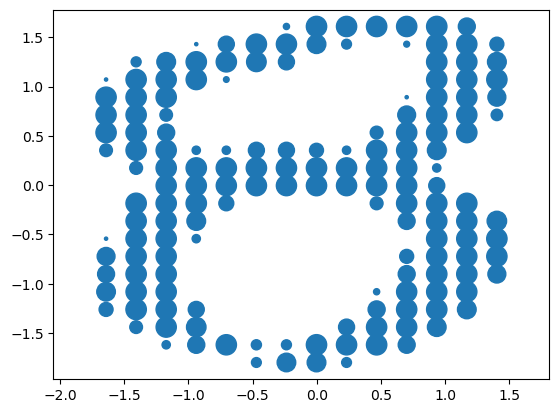

PyObject <matplotlib.collections.PathCollection object at 0x000000000138A070>

In [104]:
scatter(xx[1,:,10], xx[2,:,10], s=140 .* xx[3,:,10] .+ 87)

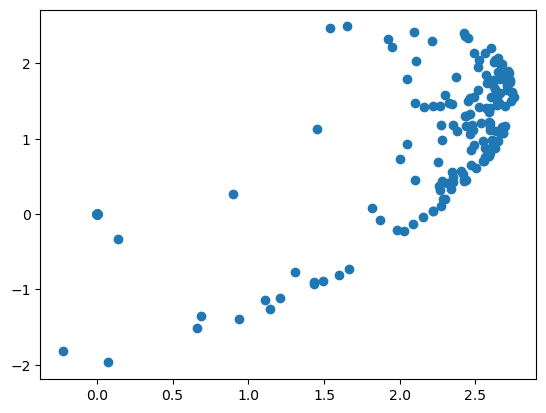

PyObject <matplotlib.collections.PathCollection object at 0x00000000013EACD0>

In [105]:
scatter(y[1,:,1], y[2,:,1])#, s=147 .*y[3,:,10] .+ 87)

In [113]:
mod_prior.α

5-element Vector{Float32}:
 0.58957666
 0.16963077
 0.4072845
 0.795733
 0.55859035

In [109]:
mod_prior = sv.prior;
mod_prior.μ .*=3

3×5×1 Array{Float32, 3}:
[:, :, 1] =
  7.10654  -1.13689  -4.50142    -2.3946    0.00204993
  5.65151   3.63746   0.0625007  -7.53207  -1.20442
 -5.72014   3.07019   6.02951    -2.3408    4.98249

In [121]:
using Random
using Zygote
function gumbel_softmax(logits::AbstractArray{T}; τ::T=1f0, hard::Bool=false, eps::Float32=1.0f-10) where T <: Real
    # logits ∈ R^{n_classes} ~ (n_classes, bs) 
    # τ ... non-negative scalar temeperature (default=1.0) https://arxiv.org/pdf/1611.01144.pdf
    # gumbel_samples = -log.(-log.(rand(Float32, size(logits)) + 1e-10) + 1e-10) # alternative version
    #.+ rand(Gumbel(Float32(0), Float32(1)), size(logits))
    gumbel_samples = -log.(-log.(Random.rand!(logits) .+ eps) .+ eps)
    y = logits .+ gumbel_samples
    y = Flux.softmax(y./τ)

    if !hard
        return y
    else
        y_hard = nothing
        Zygote.ignore() do
            # we don't want for this block of code computing gradients
            shape = size(y)
            y_hard = zeros(T, shape)
            _, ind = findmax(y, dims=1)
            y_hard[ind] .= 1
            y_hard = y_hard .- y
        end
        #print(y_hard)
        # now we bypass gradients from y_hard to y
        y = y_hard .+ y 
        return y
    end
end

gumbel_softmax (generic function with 1 method)

Float32[0.0, 0.0, 1.0, 0.0, 0.0]
size -> (1, 300, 5, 32) | type -> Array{Float32, 4} | mean -> 0.2 | var -> 0.16000333 | sum -> 9600.0 | not zero elements -> 9600) 
size -> (3, 1, 5, 1) | type -> Array{Float32, 4} | mean -> 0.38079324 | var -> 20.555727 | sum -> 5.711899 | not zero elements -> 15) 
size -> (3, 300, 32) | type -> Array{Float32, 3} | mean -> 0.5301942 | var -> 18.593428 | sum -> 15269.594 | not zero elements -> 28800) 
local function
size -> (3, 300, 32) | type -> Array{Float32, 3} | mean -> 0.52010524 | var -> 20.2295 | sum -> 14979.031 | not zero elements -> 28800) 


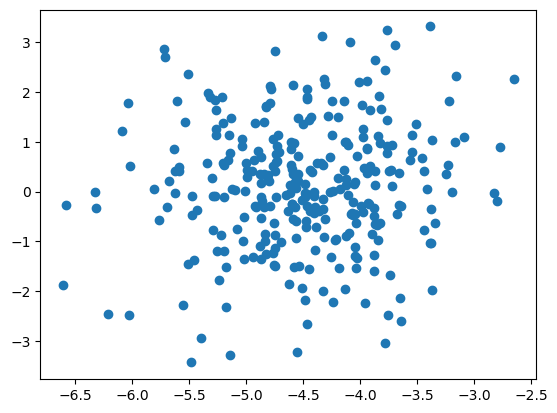

PyObject <matplotlib.collections.PathCollection object at 0x000000000237ACA0>

In [136]:
function (MoG::GenerativeMIL.Models.MixtureOfGaussians)(sample_size::Union{Int, Array{Int, 1}}, batch_size)
    # TODO for array instead of int .. maybe not needed
    # sample_size = ...
    αₒₕ = gumbel_softmax(MoG.α, hard=true)
    println(αₒₕ)
    αₒₕ = reshape(αₒₕ, (1, 1, MoG.K, 1))
    αₒₕ = repeat(αₒₕ, 1, sample_size, 1, 1) # (K) -> (1, 1, K, 1) -> (1, ss, K, 1),
    #cat([reshape(αₒₕ, (1, 1, MoG.K, 1)) for i=1:sample_size]..., dims=2)
    αₒₕ = repeat(αₒₕ, 1, 1, 1, batch_size)  # (1, ss, K, 1) -> (1, ss, K, bs)
    # cat([αₒₕ for i =1:batch_size]..., dims=4)
    αₒₕ|>GenerativeMIL.Models.check
    μ = reshape(MoG.μ, (MoG.Ds, 1, MoG.K, 1)) # (Ds, K, 1) -> (Ds, 1, K, 1) 
    Σ = reshape(MoG.Σ, (MoG.Ds, 1, MoG.K, 1)) # (Ds, K, 1) -> (Ds, 1, K, 1) 
    μ|>GenerativeMIL.Models.check
    # (1, ss, K, bs) * (Ds, 1, K, 1) -> (Ds, ss, K, bs) -> (Ds, ss, 1, bs) -> (Ds, ss, bs)
    #μ = Flux.sum( μ .* αₒₕ  , dims=3)[:,:,1,:] 
    #Σ = Flux.sum( Σ .* αₒₕ  , dims=3)[:,:,1,:] 
    μ = reshape(Flux.sum( μ .* αₒₕ  , dims=3), (:,sample_size, batch_size))
    Σ = reshape(Flux.sum( Σ .* αₒₕ  , dims=3), (:,sample_size, batch_size))
    μ|>GenerativeMIL.Models.check
    # samples from N(0,1) -> (Ds, ss, bs)
    ϵ = randn(Float32, MoG.Ds, sample_size, batch_size)
    z = μ + Flux.softplus.(Σ) .* ϵ #.* randn(Float32) # (Ds, ss, bs) + (Ds, ss, bs) * (Ds, ss, bs) -> (Ds, ss, bs)
    println("local function")
    return z
end
zz = mod_prior(300, 32)
zz|> GenerativeMIL.Models.check
scatter(zz[1,:,1], zz[2,:,1])#, s=147 .*y[3,:,10] .+ 87)

In [124]:
ones(3,2,4) .* randn() |> unique

1-element Vector{Float64}:
 0.3328614280068346

In [98]:
ones(3,2,4) .* randn()

3×2×4 Array{Float64, 3}:
[:, :, 1] =
 -0.129992  -0.129992
 -0.129992  -0.129992
 -0.129992  -0.129992

[:, :, 2] =
 -0.129992  -0.129992
 -0.129992  -0.129992
 -0.129992  -0.129992

[:, :, 3] =
 -0.129992  -0.129992
 -0.129992  -0.129992
 -0.129992  -0.129992

[:, :, 4] =
 -0.129992  -0.129992
 -0.129992  -0.129992
 -0.129992  -0.129992

In [25]:
y|>check

size -> (64, 231, 32) | type -> Array{Float32, 3} | var -> 0.99978584 | mean -> 0.003369786 | sum -> 1594.2053 | not zero elements -> 294528) 


In [64]:
Flux.var(y[1,:,10])

0.0077997334f0

In [123]:
y[1,:,30] |> GenerativeMIL.Models.check

size -> (234,) | type -> Vector{Float32} | mean -> 0.44466263 | sum -> 104.051056 | not zero elements -> 168) 


In [19]:
#y[:,:,end]

In [20]:
losses

200-element Vector{Any}:
 4.9109138616633174
 3.2231548254766906
 1.5511453734192742
 1.376289877252941
 1.5160141422933915
 1.3249798332140157
 1.1204528914874787
 1.1780680757885462
 0.9800440250442674
 0.7402565359794262
 1.0840892548637346
 0.8100583980445959
 0.7466132603850199
 ⋮
 0.5107088557775473
 0.4827751492086853
 0.44803662019413815
 0.4465033793746775
 0.5041566591931825
 0.6160068135008958
 0.49828455121592563
 0.491665753943473
 0.4906397582968852
 0.5248843718569464
 0.5801990929663784
 0.45816561409466555

In [21]:
using DelimitedFiles
outdata = Dict(:data => losses)
#save("losses1.bson", outdata)

Dict{Symbol, Vector{Any}} with 1 entry:
  :data => [4.91091, 3.22315, 1.55115, 1.37629, 1.51601, 1.32498, 1.12045, 1.17…

In [25]:
print(Flux.params(sv_tmp.encoder).==Flux.params(sv.encoder))


Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]

In [28]:
print(Flux.params(sv.encoder)[Flux.params(sv_tmp.encoder).==Flux.params(sv.encoder)] .|> size)

[(64, 64), (64, 64)]

In [29]:
unchanged_params = deepcopy(Flux.params(sv.encoder)[Flux.params(sv_tmp.encoder).==Flux.params(sv.encoder)])

2-element Vector{Any}:
 Float32[-0.1035946 -0.055361886 … 0.20891346 -0.21407235; 0.2083059 0.12511599 … -0.06408487 -0.2001316; … ; 0.18608487 0.08807347 … 0.15463728 -0.16088907; -0.11046067 0.15218392 … 0.20965809 -0.02174056]
 Float32[0.19898191 -0.04247078 … 0.0035432924 -0.071521774; 0.1756928 0.108293 … 0.023105705 -0.19747646; … ; 0.19096962 0.1671403 … 0.07329582 0.07689403; 0.16038328 0.11917222 … -0.137432 0.20649318]

In [41]:
sv.encoder.layers[end].MAB1.Multihead.WQ.W == unchanged_params[1]

true

In [42]:
sv.encoder.layers[end].MAB1.Multihead.WK.W == unchanged_params[2]

true

In [45]:
Flux.mse(sv.encoder.layers[end].I,sv_tmp.encoder.layers[end].I ) 

2.2548338f-5

In [26]:
sv.decoder

GenerativeMIL.Models.HierarchicalDecoder(Dense(3, 64), Any[InducedSetAttentionBlock( - MAB1 = MultiheadAttentionBlock(
	 - Mulithead = MultiheadAttention(
	 - heads = 4 
	 - WQ = Dense(64, 64; bias=false) 
	 - WK = Dense(64, 64; bias=false)
	 - WV = Dense(64, 64; bias=false) 
	 - WO = Dense(64, 64; bias=false) 
	 - attention = slot_attention 
	 )  
	 - FF = Chain(Dense(64, 64, relu), Dense(64, 64)) 
	 - LN1 = LayerNorm((64, 1)) 
	 - LN2 = LayerNorm((64, 1)) 
 ) 
 - MAB2 = MultiheadAttentionBlock(
	 - Mulithead = MultiheadAttention(
	 - heads = 4 
	 - WQ = Dense(64, 64; bias=false) 
	 - WK = Dense(64, 64; bias=false)
	 - WV = Dense(64, 64; bias=false) 
	 - WO = Dense(64, 64; bias=false) 
	 - attention = slot_attention 
	 )  
	 - FF = Chain(Dense(64, 64, relu), Dense(64, 64)) 
	 - LN1 = LayerNorm((64, 1)) 
	 - LN2 = LayerNorm((64, 1)) 
 )  - VB = VariationalBottleneck(
	 - prior = Chain(Dense(64, 32, relu), Dense(32, 32, relu), Dense(32, 32, relu), Dense(32, 32, relu), GenerativeMIL.Mode

In [51]:
print(Flux.params(sv_tmp.decoder).==Flux.params(sv.decoder))

Bool[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [54]:
unchanged_params_dec = deepcopy(Flux.params(sv.decoder)[Flux.params(sv_tmp.decoder).==Flux.params(sv.decoder)])

2-element Vector{Any}:
 Float32[-0.002783407 -0.12300339 … -0.14789099 0.19804448; -0.060899816 -0.20032728 … -0.009293973 -0.026616735; … ; 0.1651793 -0.07573069 … -0.18813401 0.18882243; -0.14636564 0.010214369 … -0.16233769 -0.09420151]
 Float32[-0.09238816 0.115560636 … -0.11838379 -0.00854307; 0.008925697 -0.21236357 … 0.033729646 0.013886709; … ; 0.1936226 0.097782746 … 0.15382224 0.051281985; -0.17934793 0.116944626 … 0.21345818 0.0883509]

In [61]:
unchanged_params_dec.|>size

2-element Vector{Tuple{Int64, Int64}}:
 (64, 64)
 (64, 64)

In [67]:
sv.decoder.layers[1].MAB1.Multihead.WQ.W  == unchanged_params_dec[1]

true

In [68]:
sv.decoder.layers[1].MAB1.Multihead.WK.W  == unchanged_params_dec[2]

true

In [71]:
sv.decoder.layers[1].MAB1.Multihead.WV.W  == unchanged_params_dec[1]

false

In [72]:
?save

search: save savefig savename wsave @savename imsave tmpsave tagsave @tagsave



  * `save(filename, data...)` saves the contents of a formatted file, trying to infer the format from `filename`.
  * `save(Stream{format"PNG"}(io), data...)` specifies the format directly, and bypasses the format [`query`](@ref).
  * `save(File{format"PNG"}(filename), data...)` specifies the format directly, and bypasses the format [`query`](@ref).
  * `save(f, data...; options...)` passes keyword arguments on to the saver.


In [78]:
using BSON
#tagsave("model_test_save.BSON", Dict(:model => sv, :losses => losses), safe=true)

In [82]:
#tagsave("model_test_save.bson", Dict(:model => sv, :losses => losses), safe=true)

┌ Warning: The Git repository ('F:\AI Center\GenerativeMIL') is dirty! Appending -dirty to the commit ID.
└ @ DrWatson C:\Users\ghost_000\.julia\packages\DrWatson\S4dYA\src\saving_tools.jl:65


Dict{Symbol, Any} with 3 entries:
  :gitcommit => "896ae877fbc76b75680bafe9d9c37204630cb683-dirty"
  :model     => SetVAE(HierarchicalEncoder(Dense(3, 64), Any[InducedSetAttentio…
  :losses    => Any[(2.43073, 129.363), (1.66283, 67.452), (0.896032, 35.4829),…

In [81]:
Dict(:model => sv, :losses => losses)

Dict{Symbol, Any} with 2 entries:
  :model  => SetVAE(HierarchicalEncoder(Dense(3, 64), Any[InducedSetAttentionBl…
  :losses => Any[(2.43073, 129.363), (1.66283, 67.452), (0.896032, 35.4829), (0…

In [83]:
#test = load("model_test_save.bson")

Dict{Symbol, Any} with 3 entries:
  :gitcommit => "896ae877fbc76b75680bafe9d9c37204630cb683-dirty"
  :model     => SetVAE(HierarchicalEncoder(Dense(3, 64), Any[InducedSetAttentio…
  :losses    => Any[(2.43073, 129.363), (1.66283, 67.452), (0.896032, 35.4829),…

In [25]:
try
    var(x);
    print("try")
finally
    println("finally")
end

finally


LoadError: UndefVarError: var not defined